In [1]:
import numpy as np 
from matplotlib import pyplot as plt
import cv2 

In [29]:
# In this notebook, we implemement the Gaussian Mixture Kalman Filter (GMKF) from Wills et. al. 2017

from scipy.stats import norm

class GMKF():
    def __init__(self, x_init, std_x, y_init, std_y, v_init, std_v, dynamics_params, x_mean, y_mean, v_mean, std_zx, std_zy, N_max = 5) -> None:
        # mean trajectories
        self.x_mean = x_mean
        self.y_mean = y_mean
        self.v_mean = v_mean

        # time variable
        self.t = 0

        # these are also p(x_1 | y_1) or 1|1, or t|t
        self.N = 1

        # Lateral component
        self.wx = [1]
        self.mu_x = [x_init]
        self.std_x = [std_x]
        self.P_x = [std_x**2]

        # Longitudinal component
        self.wy = [1]
        self.mu_y = np.array([y_init, v_init]).T
        self.std_y = [std_y]
        self.std_v = [std_v]
        self.P_y = np.array([[std_y**2, 0], [0, std_v**2]])

        # Dynamics model
        # dynamics params is a tuple of alpha_left, mu_left, std_left, alpha_center, mu_center, std_center, alpha_right, mu_right, std_right, std_v
        self.dynamics_params = dynamics_params 
        self.Nx = 3 # number of mixture components of the dynamics model for the lateral component
        self.N_max = N_max # maximum number of mixture components for the state
        self.A = np.array([[1, 1], [0, 1]])
        self.B = np.array([[0], [1]])
        self.C = np.array([[1, 0]])

        # Measurement model
        self.std_zx = [std_zx]
        self.std_zy = [std_zy]
        self.P_zx = [std_zx**2]
        self.P_zy = [std_zy**2]

        #

    def predict(self): # p(x_{t+1} | y_{1:t})
        # predict the state of the system at the next time step
        # the prediction is a mixture of Gaussians

        # ================== #
        # For lateral/lane change dynamics/x #
        # ================== #
        # first, we compute the number of mixture components in the prediction t+1|1:t
        N_tPlus1_t = self.N * self.Nx # N is the number of components for t|t, Nx is the number of components for t+1|t or the dynamics model
        # then, we compute the means of each mixture component
        
        mu_x_pred = np.zeros(N_tPlus1_t)
        P_x_pred = np.zeros(N_tPlus1_t)
        w_x_pred = np.zeros(N_tPlus1_t)

        for s in range(self.N): # s is the index of t|t mixture
            for j in range(self.Nx): # j is the index of t+1|t mixture, or the dynamics model. j=0: left, j=1: center, j=2: right
                l = self.Nx * s + j # lth mixture component of t+1|1:t
                
                mu_x_pred[l] = (self.x_mean[self.t+1] - self.x_mean[self.t]) + self.mu_x[s] + self.dynamics_params[1 + 3*j] # 1, 4, 7 are the means of the dynamics model
                # in dynamics_params, the variances are at index 2, 5, 8
                P_x_pred[l] = self.P_x[s] + self.dynamics_params[2 + 3*j]**2 # the variance is the sum of the variances of the dynamics and the measurement, 2, 5, 8 are the variances of the dynamics model
                w_x_pred[l] = self.wx[s] * self.dynamics_params[0 + 3*j] # the weight is the product of the weights of the dynamics and the measurement

        # ================== #
        # For longitudinal dynamics/y #
        # ================== #
        # For longitudinal component, there is just one mixture component, so it's similar to a regular Kalman Filter
        # Position
        y_tPlus1_t = self.A @ self.mu_y # mean propagation of the state
        P_tPlus1_t = self.A @ self.P_y @ self.A.T + self.B * self.dynamics_params[9]**2 # 9th index is the variance of the velocity
        w_tPlus1_t = self.wy[0]

        # at the end of the prediction step, we have 3x the number of mixture components for the state
        return mu_x_pred, P_x_pred, w_x_pred, y_tPlus1_t, P_tPlus1_t, w_tPlus1_t
    
    def update(self, zx, zy, prediction): # zx: the measured lateral (x) and longitudinal (y) position of the vehicle
        # the update follows Will's 2017 paper. 
        # prediction argument should come from self.predict()
        mu_x_pred, P_x_pred, w_x_pred, mu_y_pred, P_y_pred, w_y_pred = prediction

        # ================== #
        # For lateral/lane change dynamics/x #
        # ================== #
        # the number of posterior mixture components 
        N_tPlus1_t = mu_x_pred.shape[0]
        N_tPlus1_tPlus1 = N_tPlus1_t # because the measurement mixture has only one component
        mu_x_tPlus1_tPlus1 = np.zeros(N_tPlus1_tPlus1)
        P_x_tPlus1_tPlus1 = np.zeros(N_tPlus1_tPlus1)
        w_x_tPlus1_tPlus1 = np.zeros(N_tPlus1_tPlus1)

        for l in range(N_tPlus1_t):
            # compute the predicted measurement covariance
            sigma_tl = P_x_pred[l] + self.P_zx[0] 
            # compute the Kalman gain
            K_tl = P_x_pred[l] / sigma_tl
            # compute the posterior mean
            ex = zx - mu_x_pred[l]
            mu_x_tPlus1_tPlus1[l] = mu_x_pred[l] + K_tl * ex
            # compute the posterior covariance
            P_x_tPlus1_tPlus1[l] = P_x_pred[l] - K_tl * P_x_pred[l]
            # compute the posterior weight
            w_x_tPlus1_tPlus1[l] = w_x_pred[l] * norm.pdf(ex, 0, np.sqrt(sigma_tl))
            
        # Renormalize the weights
        w_x_tPlus1_tPlus1 = w_x_tPlus1_tPlus1 / np.sum(w_x_tPlus1_tPlus1)

        # TODO: Prune the mixture components

        # ================== #
        # For longitudinal dynamics/y #
        # ================== #
        # Like said, the longitudinal component is similar to a regular Kalman Filter
        # so there is only one mixture component
        # compute the predicted measurement covariance
        sigma_yt = self.C @ P_y_pred @ self.C.T + self.P_zy[0] # scalar
        # compute the Kalman gain
        K_yt = P_y_pred @ self.C.T / sigma_yt # 2x1
        # compute the posterior mean
        ey = zy - self.C @ mu_y_pred
        mu_y_tPlus1_tPlus1 = mu_y_pred + K_yt * ey # 2x1
        # compute the posterior covariance
        P_y_tPlus1_tPlus1 = P_y_pred - K_yt * sigma_yt * K_yt.T # 2x2
        # compute the posterior weight
        w_y_tPlus1_tPlus1 = [w_y_pred[0]]

        return mu_x_tPlus1_tPlus1, P_x_tPlus1_tPlus1, w_x_tPlus1_tPlus1, sigma_tl, mu_y_tPlus1_tPlus1, P_y_tPlus1_tPlus1, w_y_tPlus1_tPlus1, sigma_yt

    def tick_time(self):
        # move the time step forward
        self.t += 1

            





SyntaxError: invalid syntax (337152684.py, line 77)

# Unit Test & Sanity Check for GMKF Predict Function 

First, let's pick a sample trajectory, prior to smoothing.

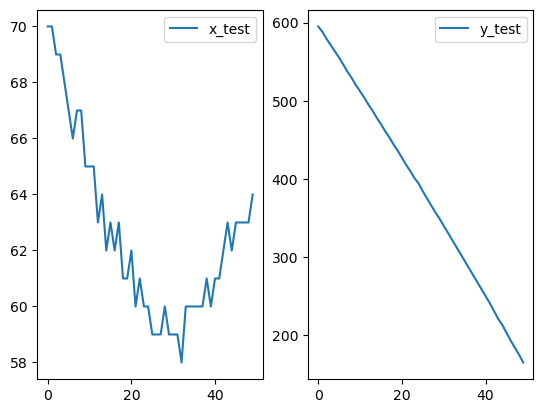

In [3]:
x_mean = np.load('x_mean.npy')
y_mean = np.load('y_mean.npy')
x_samp = np.load('x_sample_from_video.npy')
y_samp = np.load('y_sample_from_video.npy')
v_mean = np.diff(x_mean)

x_test = x_samp[0,:]
y_test = y_samp[0,:]

plt.subplot(1,2,1)
plt.plot(x_test)
# plt.plot(x_mean)
plt.legend(['x_test', 'x_mean'])
plt.subplot(1,2,2)
plt.plot(y_test)
# plt.plot(y_mean)
plt.legend(['y_test', 'y_mean'])

We will smooth this particular trajectory using GMKF.

In [4]:
def get_params(alpha_left, mu_left, std_left, alpha_center, mu_center, std_center, alpha_right, mu_right, std_right, std_v):
    return (alpha_left, mu_left, std_left, alpha_center, mu_center, std_center, alpha_right, mu_right, std_right, std_v)

In [8]:
# Initialize the filter
# alpha_left, mu_left, std_left, alpha_center, mu_center, std_center, alpha_right, mu_right, std_right, std_y
filt = GMKF(x_init=x_test[0], std_x=0.3, y_init=y_test[0], std_y=0.3, v_init=y_test[1] - y_test[0], std_v=0.2,
            dynamics_params=get_params(alpha_left=0.05, mu_left=-1.5, std_left=0.1, 
                             alpha_center=0.9, mu_center=0, std_center=0.3, 
                             alpha_right=0.05, mu_right=1.5, std_right=0.1,
                             std_v=1.2), 
            x_mean=x_mean, y_mean=y_mean, v_mean=v_mean, std_zx=0.3, std_zy=0.3)

# predict the state at the next time step
mu_x_pred, P_x_pred, w_x_pred, mu_y_pred, P_y_pred, w_y_pred, mu_v_pred, P_v_pred = filt.predict()
pred = (mu_x_pred, P_x_pred, w_x_pred, mu_y_pred, P_y_pred, w_y_pred, mu_v_pred, P_v_pred)
# update the state at the next time step
mu_x_tPlus1_tPlus1, P_x_tPlus1_tPlus1, w_x_tPlus1_tPlus1 = filt.update(zx=x_test[1], zy=y_test[1], prediction=pred)

In [6]:
# plot the GMM of the prediction
from scipy.stats import norm

# Visualization functions
def gmm_pdf(mu, P, w, x):
    pdf = 0
    for l in range(mu.shape[0]):
        pdf += w[l] * norm.pdf(x, mu[l], P[l])
    return pdf

def plot_gmm(mu, P, w):
    x = np.linspace(np.min(mu) - np.max(np.sqrt(P)) * 10, np.max(mu) + np.max(np.sqrt(P)) * 10, 200)
    plt.plot(x, gmm_pdf(mu, P, w, x))
    # add texts denoting the means of the mixture components
    for l in range(mu.shape[0]):
        plt.text(mu[l], 0, str(np.round(mu[l], 2)) + '$\pm$' + str(np.round(np.sqrt(P[l]), 2)), rotation=90, fontsize=8)


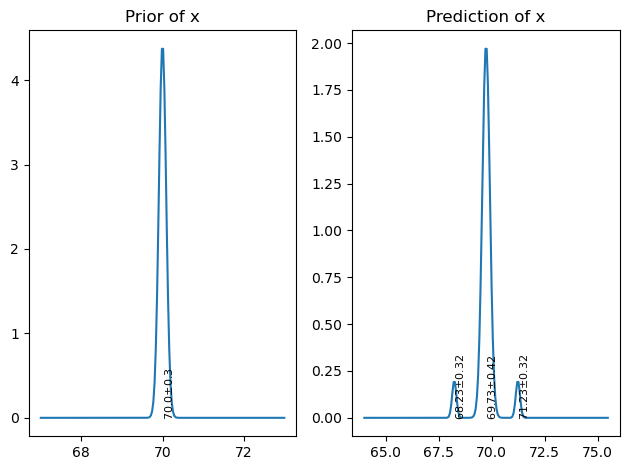

In [27]:
# Prediction of lateral (x) component
plt.figure()
plt.subplot(1,2,1)
# Prior
plot_gmm(np.array(filt.mu_x), np.array(filt.P_x), np.array(filt.wx))
plt.title('Prior of x')

plt.subplot(1,2,2)
# Prediction
plot_gmm(mu_x_pred, P_x_pred, w_x_pred)
plt.title('Prediction of x')

plt.tight_layout()


**Sanity check:** verify that the variances always increase after the prediction step 

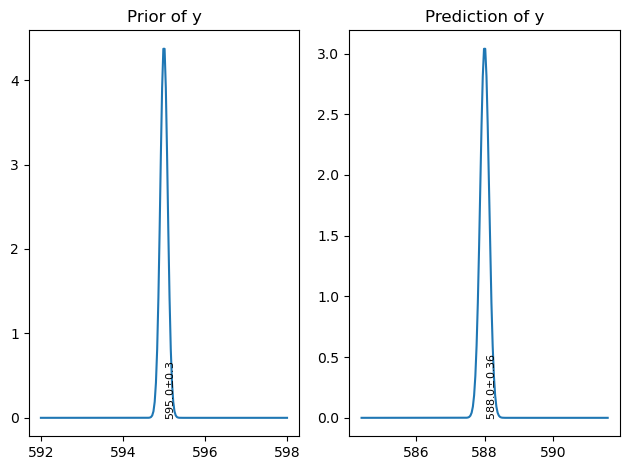

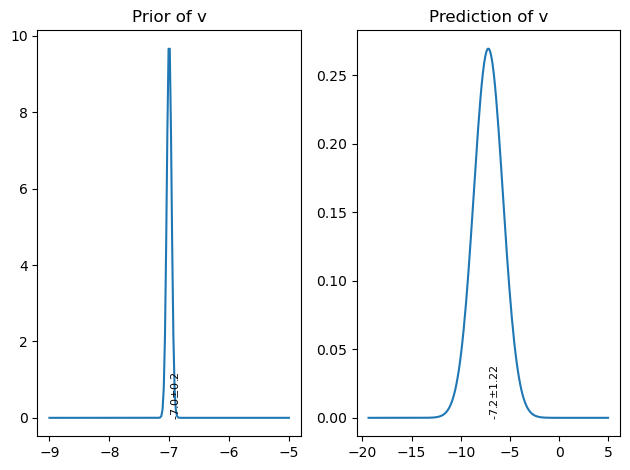

In [28]:
# ---------------------- #
# Prediction of longitudinal (y) component
plt.figure()
plt.subplot(1,2,1)
# Prior
plot_gmm(np.array(filt.mu_y), np.array(filt.P_y), np.array(filt.wy))
plt.title('Prior of y')

plt.subplot(1,2,2)
# Prediction
plot_gmm(mu_y_pred, P_y_pred, w_y_pred)
plt.title('Prediction of y')

plt.tight_layout()

# ---------------------- #
# Prediction of longitudinal velocity (v) component
plt.figure()
plt.subplot(1,2,1)
# Prior
plot_gmm(np.array(filt.mu_v), np.array(filt.P_v), np.array([1]))
plt.title('Prior of v')

plt.subplot(1,2,2)
# Prediction
plot_gmm(np.array(mu_v_pred), np.array(P_v_pred), np.array([1]))
plt.title('Prediction of v')

plt.tight_layout()

# Unit Test and Sanity Check for GMKF Update

In [10]:
w_x_tPlus1_tPlus1

array([2.04437156e-05, 9.98601813e-01, 1.37774288e-03])

(68.0, 72.0)

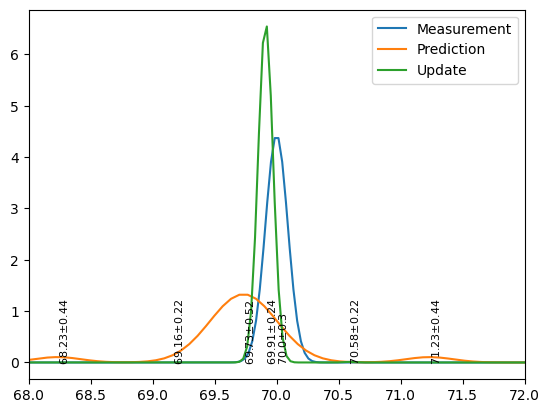

In [25]:
plot_gmm(np.array([x_test[1]]), np.array(filt.P_zx), np.array([1]))
plot_gmm(mu_x_pred, P_x_pred + filt.P_zx, w_x_pred)
plot_gmm(mu_x_tPlus1_tPlus1, P_x_tPlus1_tPlus1, w_x_tPlus1_tPlus1)
plt.legend(['Measurement', 'Prediction', 'Update'])
plt.xlim((68, 72))

In [16]:
np.array(P_x_pred) + np.array(filt.P_zx)

array([0.19, 0.27, 0.19])